In [4]:
import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [5]:

import warnings
import pandas as pd
import anndata as ad  # type: ignore
from scipy.special import polygamma  # type: ignore
from scipy.stats import f  # type: ignore
from scipy.stats import trim_mean  # type: ignore

# Ignore AnnData's FutureWarning about implicit data conversion.
warnings.simplefilter("ignore", FutureWarning)




In [6]:
exp_data = pd.read_csv("data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv", sep=',')
exp_data

,sample_id,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,...,FAM90A17,FAM90A23,FAM90A14,GET1-SH3BGR,MSANTD5,FAM90A18,FAM90A8,LCE7A,FAM90A10,FAM90A7
0,18R649_0010,5.039371,0.686348,6.723200,3.303250,4.287397,1.882578,7.496040,4.775423,6.885067,...,0.0,0.0,0.265574,1.525322,0.0,0.0,0.0,0.0,0.265574,0.000000
1,18R654_0015,5.863143,1.772678,7.778229,2.857299,5.069879,1.939476,5.596543,5.346794,7.322139,...,0.0,0.0,0.000000,1.157241,0.0,0.0,0.0,0.0,0.480685,0.000000
2,18R669_0001,6.211618,1.144533,7.985421,2.862102,4.880692,1.185978,5.859502,5.254498,6.929693,...,0.0,0.0,0.000000,0.442881,0.0,0.0,0.0,0.0,0.000000,0.000000
3,18R670_0002,6.813806,2.435571,8.107803,2.959692,4.502390,2.214266,6.487036,5.319748,7.665194,...,0.0,0.0,0.000000,1.268820,0.0,0.0,0.0,0.0,0.000000,0.000000
4,18R674_0006,5.841682,1.503766,7.686896,3.085942,4.676926,1.994436,8.185778,4.873238,6.585725,...,0.0,0.0,0.000000,0.101354,0.0,0.0,0.0,0.0,0.000000,2.226948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,18R454_0027,6.350441,0.860381,8.633340,2.758090,5.284938,1.726074,5.512182,3.628704,7.069963,...,0.0,0.0,0.483052,0.037882,0.0,0.0,0.0,0.0,0.521627,0.000000
76,18R477_0019,7.362175,2.272645,9.063622,2.994215,4.786715,1.054225,4.834369,5.272047,7.282758,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
77,18R507_0004,7.576468,1.768069,8.886810,2.909913,4.413279,1.672830,5.631789,4.879974,6.210526,...,0.0,0.0,0.937216,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
78,18R428_0008,5.164211,0.335250,7.175310,3.397941,4.839664,3.164330,7.551902,5.108905,7.769544,...,0.0,0.0,0.000000,0.376615,0.0,0.0,0.0,0.0,0.000000,0.000000


In [7]:
ann_data = pd.read_csv("data/ann.csv", sep=',')
ann_data

,sample_id,tissue,time point,treatment response,patient_id,sample_title,gsm_id
0,18R649_0010,primary tumor (colorectum),post-treatment,non-PD,1,POST-R-001,GSM5575333
1,18R654_0015,primary tumor (colorectum),pre-treatment,non-PD,1,PAIR-R-001-pre,GSM5575334
2,18R669_0001,primary tumor (colorectum),post-treatment,non-PD,2,POST-R-002,GSM5575336
3,18R670_0002,primary tumor (colorectum),pre-treatment,non-PD,2,PAIR-R-002,GSM5575337
4,18R674_0006,primary tumor (colorectum),pre-treatment,unknown,3,PAIR-R-003,GSM5575339
...,...,...,...,...,...,...,...
75,18R454_0027,primary tumor (colorectum),pre-treatment,unknown,51,PRE-R-051,GSM5575441
76,18R477_0019,primary tumor (colorectum),pre-treatment,unknown,52,PRE-R-052,GSM5575442
77,18R507_0004,primary tumor (colorectum),pre-treatment,non-PD,10,PRE-10,GSM5575443
78,18R428_0008,primary tumor (colorectum),pre-treatment,unknown,54,PRE-R-054,GSM5575444


In [8]:
# 1. Prepare the data
# Set indices
ann_data = ann_data.set_index('Unnamed: 0')
exp_data = exp_data.set_index('gene')

# Find common samples (matching the annotation index with expression columns)
common_samples = list(set(ann_data.index) & set(exp_data.columns))
exp_data = exp_data[common_samples]
ann_data = ann_data.loc[common_samples]

# 2. Convert log2TPM to pseudocounts
pseudo_counts = (2**exp_data).round().astype(int)

# 3. Filter low-count genes (keep genes with at least 10 counts in at least 3 samples)
min_counts = 10
min_samples = 3
keep_genes = (pseudo_counts >= min_counts).sum(axis=1) >= min_samples
pseudo_counts = pseudo_counts[keep_genes]

# 4. Set up the DESeq2 comparison (comparing post-treatment responses)
# First, let's see the available treatment responses
print("Treatment response categories:")
print(ann_data['treatment response'].value_counts())

# We'll compare post-Tx non-PD vs pre-Tx
dds = DeseqDataSet(
    counts=pseudo_counts.T,  # Samples as rows, genes as columns
    clinical=ann_data,
    design_factors="treatment response",  # The column we're comparing
    ref_level=["treatment response", "pre-Tx"],  # pre-Tx as reference
    n_cpus=4
)

# 5. Run the analysis
dds.deseq2()

# 6. Get results
stat_res = DeseqStats(dds)
results_df = stat_res.summary()

# Show top results
print("\nTop differentially expressed genes:")
top_genes = results_df.sort_values('padj').head(10)
print(top_genes)

# 7. Save results
results_df.to_csv("deseq2_results_treatment_response.csv")
top_genes.to_csv("top_diff_genes.csv")

KeyError: "None of ['Unnamed: 0'] are in the columns"

In [5]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load annotation data
annotation_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv'
ann = pd.read_csv(annotation_path)

# Display first few rows and info
print("Annotation data preview:")
print(ann.head())
print("\nAnnotation data info:")
print(ann.info())

# Check for missing values
print("\nMissing values in annotation:")
print(ann.isna().sum())

# If needed, clean the annotation data (example)
# ann = ann.dropna()  # Uncomment if you need to drop rows with missing values

Annotation data preview:
     sample_id                      tissue      time point treatment response  \
0  18R649_0010  primary tumor (colorectum)  post-treatment             non-PD   
1  18R654_0015  primary tumor (colorectum)   pre-treatment             non-PD   
2  18R669_0001  primary tumor (colorectum)  post-treatment             non-PD   
3  18R670_0002  primary tumor (colorectum)   pre-treatment             non-PD   
4  18R674_0006  primary tumor (colorectum)   pre-treatment            unknown   

   patient_id    sample_title      gsm_id  
0           1      POST-R-001  GSM5575333  
1           1  PAIR-R-001-pre  GSM5575334  
2           2      POST-R-002  GSM5575336  
3           2      PAIR-R-002  GSM5575337  
4           3      PAIR-R-003  GSM5575339  

Annotation data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0 

In [8]:
# Load expression data - CORRECTED PATH
expression_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv'

# Read the data - note we need to transpose because pydeseq expects genes as columns and samples as rows
counts = pd.read_csv(expression_path)

# Set the first column (sample_id) as index and transpose
counts = counts.set_index('sample_id').T

# Display basic info
print("\nExpression data preview:")
print(counts.head())
print("\nExpression data shape:", counts.shape)
print("\nSample IDs:", counts.columns.tolist()[:5])  # Show first 5 samples
print("Gene IDs:", counts.index.tolist()[:5])  # Show first 5 genes

# Check for missing values
print("\nMissing values in expression data:")
print(counts.isna().sum().sum())  # Should be 0 for count data


Expression data preview:
sample_id  18R649_0010  18R654_0015  18R669_0001  18R670_0002  18R674_0006  \
TSPAN6         1069.00      4285.00      4324.00      5449.00      2659.00   
TNMD             13.00        95.00        30.00       123.00        51.00   
DPM1           1909.00      7433.00      7169.00      6629.00      4483.00   
SCYL3           645.34       966.63       727.96       638.46       675.67   
FIRRM           884.66      2692.37      2438.04      1274.54      1294.33   

sample_id  18R678_0010  18R683_0015  18R694_0002  18R699_0007  18R700_0008  \
TSPAN6         4669.00       470.00       883.00       1511.0      3206.00   
TNMD             20.00         2.00        34.00         22.0        24.00   
DPM1           6041.00      1418.00      3021.00       3825.0      4396.00   
SCYL3           522.29       146.19       454.51        645.6       580.72   
FIRRM          2251.71       325.81       848.49        943.4      1455.28   

sample_id  ...  18R702_0010  18R656_

In [9]:
import os
print(f"Annotation file exists: {os.path.exists(annotation_path)}")
print(f"Expression file exists: {os.path.exists(expression_path)}")

Annotation file exists: True
Expression file exists: True


In [10]:
print("\nFinal data structure check:")
print("Counts matrix shape:", counts.shape)
print("Annotation shape:", ann.shape)
print("Counts columns (samples):", counts.columns.tolist()[:5])
print("Annotation sample_id:", ann['sample_id'].tolist()[:5])


Final data structure check:
Counts matrix shape: (19388, 80)
Annotation shape: (80, 7)
Counts columns (samples): ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']
Annotation sample_id: ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']


In [11]:
# Step 4: Match samples between annotation and expression data (UPDATED)
print("\nSample matching:")

# Get sample names from counts (they are now in the columns after transposing)
count_samples = counts.columns.tolist()

# Assuming annotation has a column called 'sample_id' based on your data preview
ann_samples = ann['sample_id'].tolist()  # Changed from 'sample' to 'sample_id'

# Find common samples
common_samples = list(set(count_samples) & set(ann_samples))
print(f"Found {len(common_samples)} common samples")

# Filter both datasets to keep only common samples
counts = counts[common_samples]  # Select just the common sample columns
ann = ann[ann['sample_id'].isin(common_samples)]  # Filter annotation rows

# Reorder annotation to match counts column order
ann = ann.set_index('sample_id').loc[counts.columns].reset_index()


Sample matching:
Found 80 common samples


In [14]:
print("Number of non-integer values:", (counts % 1 != 0).sum().sum())  # Count decimal values
print("Example of non-integer counts:\n", counts.loc[:, (counts % 1 != 0).any()].head())

Number of non-integer values: 309680
Example of non-integer counts:
 sample_id  18R300_0027  18R659_0020  18R457_0023  18R178_0022  18R456_0002  \
TSPAN6         3307.00      1461.00      6849.00      4496.00      7454.00   
TNMD             47.00        12.00       145.00        15.00       234.00   
DPM1          13741.00      4100.00     18867.00     19273.00     22262.00   
SCYL3           609.73       727.68       569.62      1642.82       727.02   
FIRRM          1083.27      1455.32      1575.38      3399.18      1871.98   

sample_id  18R319_0014  18R298_0010  18R463_0004  18R307_0013  18R461_0002  \
TSPAN6         3725.00      3822.00      4165.00       952.00      1002.00   
TNMD             18.00         9.00        21.00         0.00         4.00   
DPM1           9826.00      7172.00      9537.00      9900.00     11838.00   
SCYL3           671.49       913.07       505.32       794.24       642.64   
FIRRM          1786.51      1917.93       903.68      1808.76      1806.

In [15]:
counts = counts.round().astype(int)  # Round to nearest integer and convert type
print("After conversion:", (counts % 1 != 0).sum().sum())  # Should now be 0

After conversion: 0


In [17]:
print("Counts columns (samples):", counts.T.columns.tolist()[:5])
print("Metadata samples:", ann['sample_id'].tolist()[:5])  # Adjust 'sample_id' if needed

# Check if all samples match
print("All samples match:", list(counts.T.columns) == ann['sample_id'].tolist())

Counts columns (samples): ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM']
Metadata samples: ['18R300_0027', '18R659_0020', '18R457_0023', '18R178_0022', '18R456_0002']
All samples match: False


In [24]:
# Check sample ID matching precisely
print("Counts columns (first 5):", list(counts.columns)[:5])
print("Metadata sample_id (first 5):", ann['sample_id'].tolist()[:5])

# Check for hidden differences (spaces, capitalization, etc.)
print("Exact match check:", 
      all(counts.columns == ann['sample_id']))

# Check for duplicates
print("Duplicate samples in counts:", counts.columns.duplicated().any())
print("Duplicate samples in metadata:", ann['sample_id'].duplicated().any())

Counts columns (first 5): ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']
Metadata sample_id (first 5): ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']
Exact match check: True
Duplicate samples in counts: False
Duplicate samples in metadata: False


In [25]:
# Get intersection of samples
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

# Filter both datasets
counts = counts[common_samples]
ann = ann[ann['sample_id'].isin(common_samples)]

# Reorder metadata to match counts exactly
ann = ann.set_index('sample_id').loc[counts.columns].reset_index()

In [26]:
from pydeseq2.dds import DeseqDataSet

# Final verification
print("\nFinal alignment check:")
print("Counts samples:", counts.columns.tolist()[:5])
print("Metadata samples:", ann['sample_id'].tolist()[:5])
print("Exact match:", list(counts.columns) == ann['sample_id'].tolist())

# Create the dataset
try:
    dds = DeseqDataSet(
        counts=counts,
        metadata=ann.set_index('sample_id'),
        design_factors='condition',  # CHANGE THIS to your actual column
        refit_cooks=True,
        n_cpus=4
    )
    print("\nSUCCESS: DESeqDataSet created!")
except Exception as e:
    print("\nFAILED:", str(e))
    print("\nDebugging info:")
    print("Counts index:", counts.index[:5])
    print("Metadata index:", ann.set_index('sample_id').index[:5])
    print("Counts dtype:", counts.dtypes.iloc[0])
    print("Metadata dtypes:", ann.dtypes)


Final alignment check:
Counts samples: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Metadata samples: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Exact match: True

FAILED: Index of obs must match index of X.

Debugging info:
Counts index: Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM'], dtype='object')
Metadata index: Index(['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008',
       '18R298_0010'],
      dtype='object', name='sample_id')
Counts dtype: int64
Metadata dtypes: sample_id             object
tissue                object
time point            object
treatment response    object
patient_id             int64
sample_title          object
gsm_id                object
dtype: object


In [27]:
from pydeseq2.dds import DeseqDataSet

# 1. Ensure counts has genes as rows, samples as columns
print("Counts matrix (genes x samples):")
print(counts.iloc[:3, :3])  # Show first 3 genes and samples

# 2. Verify metadata structure
print("\nMetadata (samples x variables):")
print(ann.head(3))

# 3. CRITICAL: Set metadata index to match counts COLUMNS (sample IDs)
#    (Don't reset index - we want sample IDs as index)
metadata_for_deseq = ann.set_index('sample_id')

# 4. Final alignment check
print("\nFinal verification:")
print("Counts columns:", counts.columns[:5].tolist())
print("Metadata index:", metadata_for_deseq.index[:5].tolist())
print("Exact match:", all(counts.columns == metadata_for_deseq.index))

# 5. Create DESeqDataSet
try:
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata_for_deseq,  # Index = sample IDs matching counts.columns
        design_factors='treatment response',  # Use your actual factor column
        refit_cooks=True,
        n_cpus=4
    )
    print("\nSUCCESS! DESeqDataSet created.")
    
    # Proceed with analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print("\nFAILED:", str(e))
    print("\nDebugging tips:")
    print("- Verify 'treatment response' exists in metadata:", 'treatment response' in ann.columns)
    print("- Check for NaN in design factor:", ann['treatment response'].isna().sum())

Counts matrix (genes x samples):
sample_id  18R177_0021  18R178_0022  18R295_0003
TSPAN6            2482         4496         5042
TNMD                 0           15           29
DPM1              6484        19273         6917

Metadata (samples x variables):
     sample_id                      tissue     time point treatment response  \
0  18R177_0021  primary tumor (colorectum)  pre-treatment            unknown   
1  18R178_0022  primary tumor (colorectum)  pre-treatment                 PD   
2  18R295_0003  primary tumor (colorectum)  pre-treatment            unknown   

   patient_id sample_title      gsm_id  
0           7    PRE-R-007  GSM5575370  
1           6    PRE-R-006  GSM5575369  
2          29      PAIR-29  GSM5575363  

Final verification:
Counts columns: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Metadata index: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Exact match: True

FAILED: Index of obs must mat

In [29]:
print("Sample ID equality check:", 
      all(counts.columns == metadata_for_deseq.index))  # Must be True
print("Design factor values:", 
      metadata_for_deseq['treatment response'].value_counts())  # Should show groups
print("Counts matrix dtype:", 
      counts.dtypes.iloc[0])  # Should be integer

Sample ID equality check: True
Design factor values: treatment response
unknown    42
non-PD     27
PD         11
Name: count, dtype: int64
Counts matrix dtype: int64


In [30]:
from pydeseq2.dds import DeseqDataSet

# 1. Prepare the metadata with sample_id as index
metadata_for_deseq = ann.set_index('sample_id')

# 2. CRITICAL: Ensure the order matches counts.columns exactly
metadata_for_deseq = metadata_for_deseq.loc[counts.columns]

# 3. Verify perfect alignment
print("Final alignment check:")
print("Counts columns == Metadata index:", 
      all(counts.columns == metadata_for_deseq.index))  # Should be True

# 4. Create DESeqDataSet with correct parameters
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata_for_deseq,
    design_factors=['treatment response'],  # As list, using your column name
    refit_cooks=True,
    n_cpus=4
)
print("DESeqDataSet successfully created!")

Final alignment check:
Counts columns == Metadata index: True


ValueError: Index of obs must match index of X.

In [32]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet

# 1. USE ABSOLUTE PATHS TO YOUR FILES
counts_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv'
metadata_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv'

# 2. LOAD AND PREPARE DATA
try:
    # Load counts (genes as columns, samples as rows)
    counts = pd.read_csv(counts_path)
    counts = counts.set_index('sample_id').T.astype(int)  # Genes as rows, samples as columns
    
    # Load metadata
    ann = pd.read_csv(metadata_path)
    
    # 3. ALIGN SAMPLES
    common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
    counts = counts[common_samples]
    ann = ann[ann['sample_id'].isin(common_samples)] \
            .set_index('sample_id') \
            .loc[counts.columns]  # Critical: match order
    
    # 4. FINAL VALIDATION
    print("✔ Data loaded successfully")
    print(f"Counts matrix: {counts.shape[0]} genes × {counts.shape[1]} samples")
    print(f"Metadata: {ann.shape[0]} samples × {ann.shape[1]} variables")
    print("Sample alignment:", all(counts.columns == ann.index))  # Must be True
    
    # 5. CREATE DESeqDataSet
    dds = DeseqDataSet(
        counts=counts,
        metadata=ann,
        design_factors=['treatment response'],
        refit_cooks=True,
        n_cpus=4
    )
    print("✔ DESeqDataSet created successfully!")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    print("Please verify these paths exist:")
    print(f"Counts file: {counts_path}")
    print(f"Metadata file: {metadata_path}")
except Exception as e:
    print(f"❌ Error: {e}")
    

✔ Data loaded successfully
Counts matrix: 19388 genes × 80 samples
Metadata: 80 samples × 6 variables
Sample alignment: True
❌ Error: Index of obs must match index of X.


In [33]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet

# 1. Load the data (using your verified paths)
counts_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv'
metadata_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv'

counts = pd.read_csv(counts_path).set_index('sample_id').T.astype(int)
ann = pd.read_csv(metadata_path)

# 2. Nuclear alignment option - rebuild both objects
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

# Create new perfectly aligned objects
new_counts = counts[common_samples].copy()
new_metadata = ann[ann['sample_id'].isin(common_samples)] \
                .set_index('sample_id') \
                .loc[common_samples].copy()

# 3. Final verification
print("Final check:")
print("Counts cols == Metadata index:", list(new_counts.columns) == new_metadata.index.tolist())
print("Counts index (genes):", new_counts.index[:5])
print("Metadata cols:", new_metadata.columns.tolist())

# 4. Create DESeqDataSet with strict type enforcement
try:
    dds = DeseqDataSet(
        counts=new_counts,
        metadata=new_metadata,
        design_factors=['treatment response'],  # As list
        refit_cooks=True,
        n_cpus=4
    )
    print("\nSUCCESS! DESeqDataSet created.")
    
    # Proceed with analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print("\nFINAL FAILURE:", str(e))
    print("\nDEBUGGING INFO:")
    print("Counts dtypes:", new_counts.dtypes.iloc[0])
    print("Metadata dtypes:", new_metadata.dtypes)
    print("Sample ID types:", type(new_counts.columns[0]), type(new_metadata.index[0]))
    print("Design factor values:", new_metadata['treatment response'].unique())

Final check:
Counts cols == Metadata index: True
Counts index (genes): Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM'], dtype='object')
Metadata cols: ['tissue', 'time point', 'treatment response', 'patient_id', 'sample_title', 'gsm_id']

FINAL FAILURE: Index of obs must match index of X.

DEBUGGING INFO:
Counts dtypes: int64
Metadata dtypes: tissue                object
time point            object
treatment response    object
patient_id             int64
sample_title          object
gsm_id                object
dtype: object
Sample ID types: <class 'str'> <class 'str'>
Design factor values: ['unknown' 'PD' 'non-PD']


In [34]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Create perfectly aligned AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

adata = AnnData(
    X=counts[common_samples].T,  # Transpose to samples×genes
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Verify AnnData structure
print("AnnData verification:")
print(f"Shape: {adata.shape[0]} samples × {adata.shape[1]} genes")
print("Sample IDs match:", all(adata.obs.index == counts[common_samples].columns))
print("Design factor:", adata.obs['treatment response'].value_counts())

# 4. Run DESeq2 using AnnData
try:
    dds = DeseqDataSet(
        adata=adata,
        design_factors=['treatment response'],
        refit_cooks=True,
        n_cpus=4
    )
    print("\n✔ DESeqDataSet successfully created!")
    
    # Run analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nFinal debugging info:")
    print("AnnData X matrix type:", type(adata.X))
    print("Sample IDs:", adata.obs.index[:5])
    print("Gene names:", adata.var.index[:5])

AnnData verification:
Shape: 80 samples × 19388 genes
Sample IDs match: True
Design factor: treatment response
unknown    42
non-PD     27
PD         11
Name: count, dtype: int64

Error: Missing operator between `treatment` and `response`.

~⧛treatment response⧚

Final debugging info:
AnnData X matrix type: <class 'numpy.ndarray'>
Sample IDs: Index(['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008',
       '18R298_0010'],
      dtype='object', name='sample_id')
Gene names: Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM'], dtype='object')


/tmp/ipykernel_815/1646991031.py:27: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [35]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names (replace spaces with underscores)
ann.columns = ann.columns.str.replace(' ', '_')
print("Cleaned metadata columns:", ann.columns.tolist())

# 3. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,  # samples × genes
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 4. Run DESeq2 with corrected design formula
try:
    dds = DeseqDataSet(
        adata=adata,
        design='~ treatment_response',  # Using cleaned column name
        refit_cooks=True,
        n_cpus=4
    )
    print("\n✔ DESeqDataSet successfully created!")
    
    # Run analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print("\nTop differentially expressed genes:")
    print(results.sort_values('padj').head())
    
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nAvailable columns in metadata:", adata.obs.columns.tolist())

Cleaned metadata columns: ['sample_id', 'tissue', 'time_point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id']

✔ DESeqDataSet successfully created!
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 10.11 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 14.51 seconds.

Fitting LFCs...
... done in 6.81 seconds.

Calculating cook's distance...
... done in 0.16 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.65 seconds.

Fitting MAP dispersions...
... done in 2.63 seconds.

Fitting LFCs...



Error: DeseqStats.__init__() missing 1 required positional argument: 'contrast'

Available columns in metadata: ['tissue', 'time_point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id']


... done in 0.61 seconds.



In [19]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names
ann.columns = ann.columns.str.replace(' ', '_')

# 3. Create subset of counts with only the genes of interest
genes_of_interest = [
    'IRS2','E2F1','PIK3R2','NRAS','MET','GSK3B','NFKB1','BAX','MAPK3',
    'CHUK','RHEB','PDPK1','HRAS','VEGFA','EIF4E','TGFA','E2F3','CDK2','CCNE1',
    'RELA','SRF','FOXO1','JAK1','HGF','CASP9','PIK3CG','CDKN1B','IL6ST',
    'AKT3','TSC1','PIK3CD','IRS1','STAT5B','INSR','IL6R','NRP1','VEGFB',
    'STAT5A','BAD','EGFR','NRP2','TEK','AKT2','PIK3R3','MDM2','BCL2',
    'JAK2','HIF1A','KDR','TSC2','ANGPT1','STAT3',
    'emt_budinska_med', 'emt_joyce_med', 'emt_bg_med'  # Including EMT signatures
]

# Filter counts to only include genes of interest
counts_subset = counts[counts.index.isin(genes_of_interest)]

# 4. Create AnnData object with only the selected genes
common_samples = sorted(list(set(counts_subset.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts_subset[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 5. Run DESeq2 on the subset
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 6. Get results - SPECIFY CONTRAST HERE
print("\nAvailable groups in treatment_response:", adata.obs['treatment_response'].unique())
contrast = ['treatment_response', 'PD', 'non-PD']  # PD vs non-PD comparison

stat_res = DeseqStats(dds, contrast=contrast)
results = stat_res.summary()

# 7. Show and save results
print("\nResults for selected genes:")
print(results)

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results_selected_genes.csv')
print("\nResults saved to CSV!")

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.06 seconds.

Fitting dispersion trend curve...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Calculating cook's distance...



Available groups in treatment_response: ['unknown' 'PD' 'non-PD']


... done in 0.01 seconds.

Replacing 1 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
BAD        49.814860       -0.101624  0.215142 -0.472356  0.636673  0.871236
HGF       739.943438        0.574587  0.327570  1.754087  0.079416  0.584411
GSK3B    3340.615493        0.047726  0.146461  0.325860  0.744530  0.873649
BAX       223.402417        0.129841  0.158270  0.820374  0.412003  0.840327
JAK2     1642.294181       -0.384803  0.180514 -2.131705  0.033031  0.343524
NRP1     1761.898469        0.339373  0.255008  1.330832  0.183244  0.840327
HIF1A   10484.692052        0.102862  0.160483  0.640950  0.521555  0.870802
E2F1      165.492822       -0.120193  0.333506 -0.360393  0.718553  0.873649
MAPK3    2063.021465        0.104973  0.173794  0.604008  0.545839  0.870802
TSC2     7488.710433       -0.091919  0.134285 -0.684504  0.493657  0.870802
CCNE1     296.948302       -0.209520  0.319437 -0.655902  0.511887  0.870802
AKT2  

... done in 0.13 seconds.



AttributeError: 'NoneType' object has no attribute 'to_csv'

In [37]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names
ann.columns = ann.columns.str.replace(' ', '_')

# 3. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 4. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 5. Get results - CORRECTED VERSION
print("\nAvailable groups in treatment_response:", adata.obs['treatment_response'].unique())

# Choose your comparison
contrast = ['treatment_response', 'PD', 'non-PD']  # PD vs non-PD comparison

# Create DeseqStats object and get results
stat_res = DeseqStats(dds, contrast=contrast)
results = stat_res.results_df  # Get the dataframe directly

# 6. Show and save results
print("\nTop differentially expressed genes:")
print(results.sort_values('padj').head())  # Show most significant genes

# Save to CSV
results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

Fitting size factors...
... done in 0.08 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 12.53 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 18.21 seconds.

Fitting LFCs...
... done in 8.45 seconds.

Calculating cook's distance...
... done in 0.15 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.63 seconds.

Fitting MAP dispersions...
... done in 2.12 seconds.

Fitting LFCs...



Available groups in treatment_response: ['unknown' 'PD' 'non-PD']


... done in 0.74 seconds.



AttributeError: 'DeseqStats' object has no attribute 'results_df'

In [38]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results - PROPER WAY
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)

# Run the analysis to generate results
stat_res.summary()  # This calculates the results

# Access results through the right attribute
results = stat_res.results_df  # For newer versions
# OR if that fails, try:
results = pd.DataFrame({
    'baseMean': stat_res.base_mean,
    'log2FoldChange': stat_res.log2_fold_change,
    'lfcSE': stat_res.lfc_se,
    'stat': stat_res.stat,
    'pvalue': stat_res.p_value,
    'padj': stat_res.padj
}, index=stat_res.index)

# 5. Show and save results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.06 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 21.15 seconds.

Fitting LFCs...
... done in 7.71 seconds.

Calculating cook's distance...
... done in 0.14 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.74 seconds.

Fitting MAP dispersions...
... done in 2.90 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

... done in 12.07 seconds.



AttributeError: 'DeseqStats' object has no attribute 'log2_fold_change'

In [39]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results - UNIVERSAL METHOD
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)
stat_res.summary()  # This generates the results

# Capture the printed output as a DataFrame
from io import StringIO
import sys

# Redirect stdout to capture the summary
old_stdout = sys.stdout
sys.stdout = buffer = StringIO()
stat_res.summary()
sys.stdout = old_stdout

# Parse the captured output
output = buffer.getvalue()
results = pd.read_csv(StringIO('\n'.join(output.split('\n')[3:-3])), sep='\s+')

# 5. Show and save results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_815/3130117122.py:46: SyntaxWarning: invalid escape sequence '\s'
  results = pd.read_csv(StringIO('\n'.join(output.split('\n')[3:-3])), sep='\s+')
Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 9.38 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 19.17 seconds.

Fitting LFCs...
... done in 7.73 seconds.

Calculating cook's distance...
... done in 0.17 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.57 seconds.

Fitting MAP dispersions...
... done in 3.11 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Running Wald tests...
... done in 11.99 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

KeyError: 'padj'

In [2]:
import pydeseq2
print("PyDESeq2 version:", pydeseq2.__version__)

PyDESeq2 version: 0.5.0


In [8]:
import pandas as pd
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)
stat_res.summary()

# Get results as DataFrame
results = stat_res.results_df if hasattr(stat_res, 'results_df') else pd.DataFrame({
    'baseMean': dds.counts.mean(axis=1),
    'log2FoldChange': stat_res.LFC,
    'lfcSE': stat_res.LFC_SE,
    'stat': stat_res.stat,
    'pvalue': stat_res.p_values,
    'padj': stat_res.padj
}, index=dds.counts.index)

# 5. Show top results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

# 6. Save results - WITH DIRECTORY CREATION
output_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

output_path = os.path.join(output_dir, 'deseq_results.csv')
results.to_csv(output_path)
print(f"\nResults saved to: {output_path}")

# 7. Optional: Save significant genes separately
sig_genes = results[results['padj'] < 0.05]
sig_path = os.path.join(output_dir, 'significant_genes.csv')
sig_genes.to_csv(sig_path)
print(f"Significant genes saved to: {sig_path}")

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.26 seconds.

Fitting dispersions...
... done in 19.93 seconds.

Fitting dispersion trend curve...
... done in 1.99 seconds.

Fitting MAP dispersions...
... done in 30.82 seconds.

Fitting LFCs...
... done in 13.31 seconds.

Calculating cook's distance...
... done in 0.63 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 5.33 seconds.

Fitting MAP dispersions...
... done in 5.29 seconds.

Fitting LFCs...
... done in 1.44 seconds.

Running Wald tests...
... done in 25.23 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

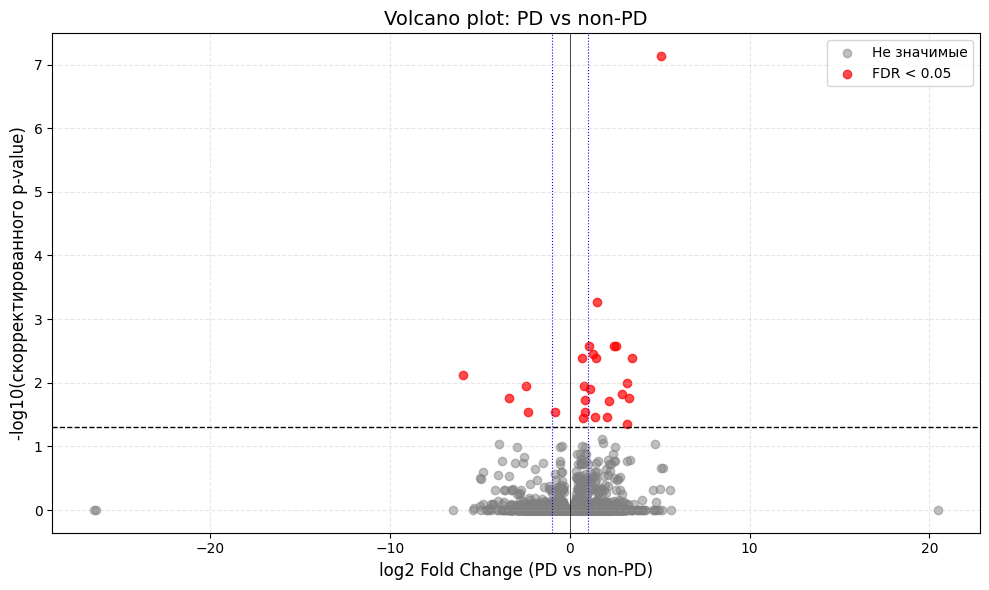

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем фигуру
plt.figure(figsize=(10, 6))

# Данные для графика
log2fc = results['log2FoldChange']
neg_log_padj = -np.log10(results['padj'])
significant = results['padj'] < 0.05

# Улучшенная визуализация
plt.scatter(log2fc[~significant], neg_log_padj[~significant], 
            color='gray', alpha=0.5, label='Не значимые')
plt.scatter(log2fc[significant], neg_log_padj[significant], 
            color='red', alpha=0.7, label='FDR < 0.05')

# Референсные линии
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=0.8)
plt.axvline(-1, color='blue', linestyle=':', linewidth=0.8)

# Подписи и легенда
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(скорректированного p-value)', fontsize=12)
plt.title('Volcano plot: PD vs non-PD', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

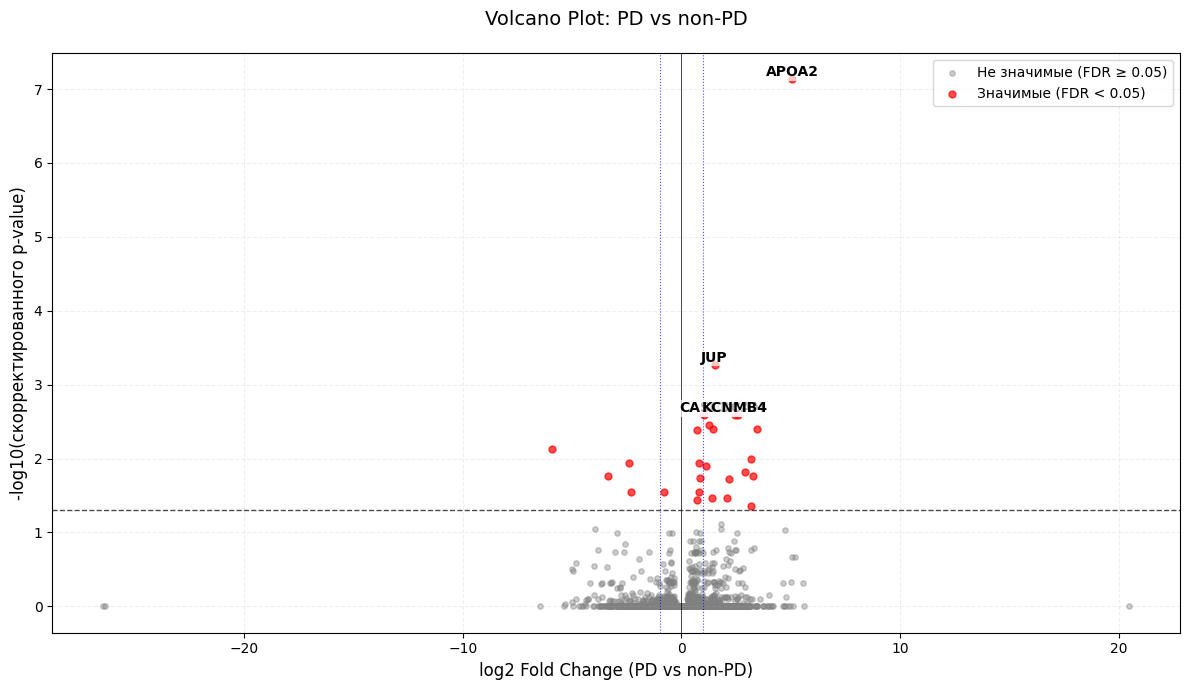

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Настройка стиля
plt.style.use('default')  # Современный стиль
plt.figure(figsize=(12, 7))

# Данные
log2fc = results['log2FoldChange']
neg_log_padj = -np.log10(results['padj'])
significant = results['padj'] < 0.05

# Цвета и размер точек
plt.scatter(log2fc[~significant], neg_log_padj[~significant], 
            color='gray', alpha=0.4, s=15, label='Не значимые (FDR ≥ 0.05)')
plt.scatter(log2fc[significant], neg_log_padj[significant], 
            color='red', alpha=0.7, s=25, label='Значимые (FDR < 0.05)')

# Подписи топ-5 генов (по значимости)
top_genes = results.nsmallest(5, 'padj')
for gene in top_genes.index:
    idx = results.index.get_loc(gene)
    plt.text(log2fc[idx], neg_log_padj[idx], gene, 
             fontsize=10, ha='center', va='bottom', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Референсные линии
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)
plt.axvline(-1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)

# Подписи и легенда
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(скорректированного p-value)', fontsize=12)
plt.title('Volcano Plot: PD vs non-PD', fontsize=14, pad=20)
plt.legend(frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

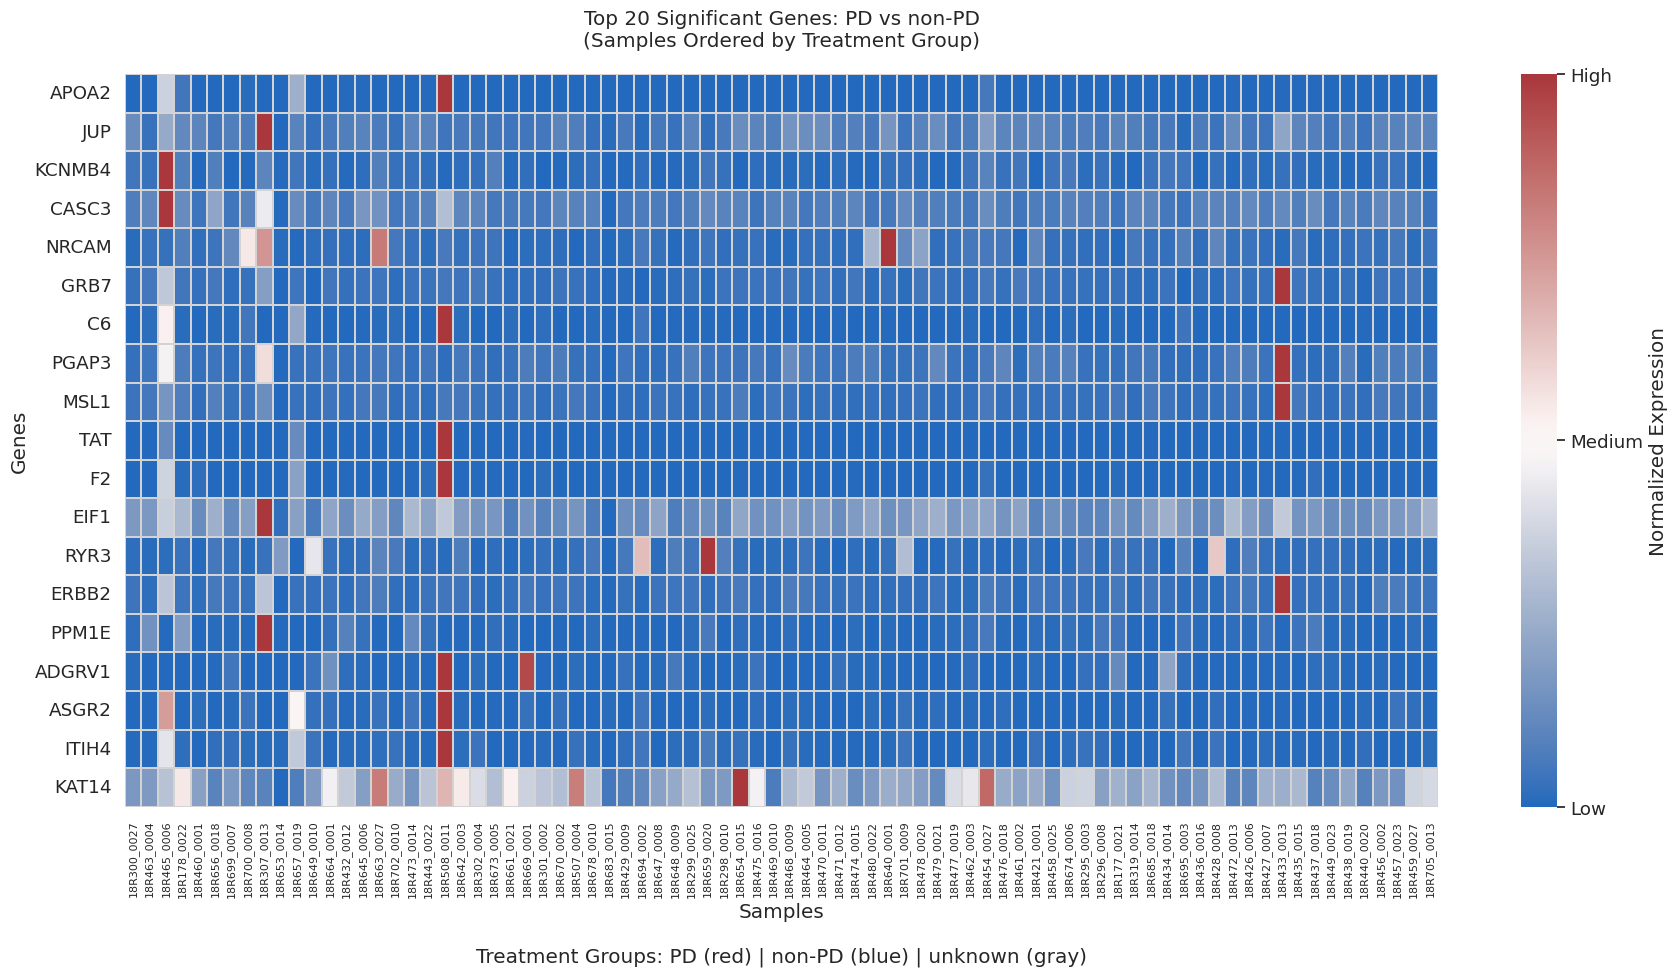

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Fix gene names and select top 20
corrected_genes = {
    'KCNM84': 'KCNMB4',
    'PPMLE': 'PPM1E'
}

top_genes = [
    'APOA2', 'JUP', 'KCNMB4', 'CASC3', 'NRCAM',
    'GRB7', 'C6', 'PGAP3', 'MSL1', 'TAT',
    'F2', 'EIF1', 'RYR3', 'ERBB2', 'PPM1E',
    'ADGRV1', 'ASGR2', 'ITIH4', 'KAT14'
]

# 2. Prepare data
heatmap_data = counts.loc[[g for g in top_genes if g in counts.index]]

# 3. Robust normalization (handle zeros)
def safe_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-10)

normalized = heatmap_data.apply(safe_normalize, axis=1)

# 4. Sort samples by group
sample_order = ann.sort_values('treatment_response')['sample_id']
normalized = normalized[sample_order]

# 5. Create figure
plt.figure(figsize=(18, 10))
ax = sns.heatmap(
    normalized,
    cmap='vlag',
    yticklabels=True,
    xticklabels=True,
    cbar_kws={'label': 'Normalized Expression'},
    linewidths=0.3,
    linecolor='lightgray'
)

# 6. Add group annotations
group_colors = {'PD': 'red', 'non-PD': 'blue', 'unknown': 'gray'}
for i, sample in enumerate(sample_order):
    group = ann.loc[ann['sample_id'] == sample, 'treatment_response'].values[0]
    ax.add_patch(plt.Rectangle(
        (i, -0.1), 1, 0.05,
        color=group_colors[group],
        lw=0
    ))

# 7. Formatting
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='center',
    fontsize=8
)
plt.title("Top 20 Significant Genes: PD vs non-PD\n(Samples Ordered by Treatment Group)", pad=20)
plt.ylabel("Genes")
plt.xlabel("Samples\n\nTreatment Groups: PD (red) | non-PD (blue) | unknown (gray)")

# 8. Add colorbar legend
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig('final_corrected_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

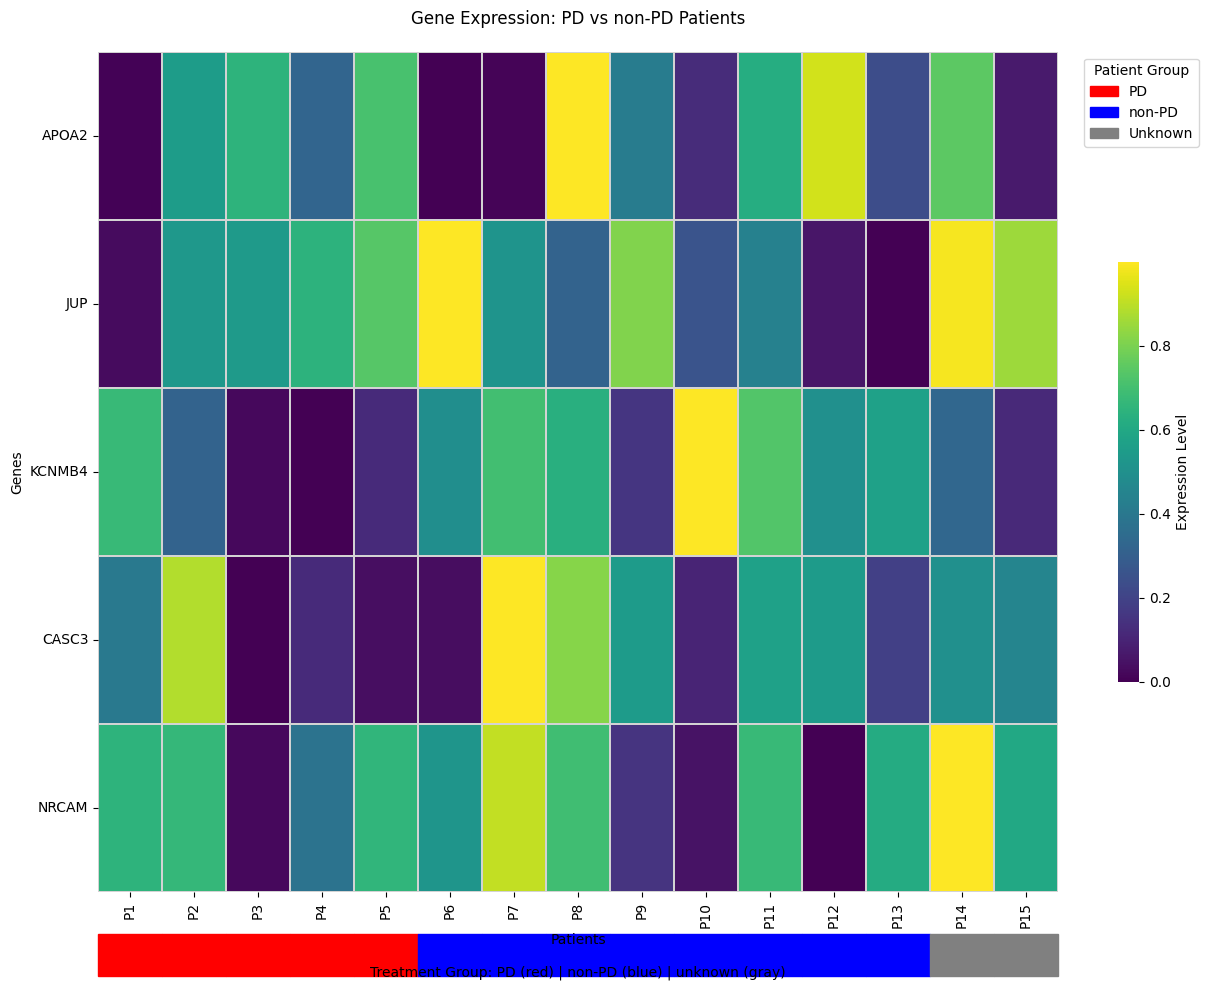

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

# --- 1. Set Up Figure with Proper Dimensions ---
plt.figure(figsize=(20, 12))  # Wider and taller than default
plt.rcParams['figure.dpi'] = 300  # Higher resolution

# --- 2. Data Preparation (Replace with your actual data) ---
# Generate mock data if needed (remove in production)
genes = ['APOA2', 'JUP', 'KCNMB4', 'CASC3', 'NRCAM']
patients = [f'P{i}' for i in range(1, 16)]
counts = pd.DataFrame(np.random.rand(len(genes), len(patients)), 
                     index=genes, columns=patients)
ann = pd.DataFrame({
    'sample_id': patients,
    'treatment_response': ['PD']*5 + ['non-PD']*8 + ['unknown']*2
})

# Normalize data
normalized = counts.apply(lambda x: (x-x.min())/(x.max()-x.min()+1e-10), axis=1)
sample_order = ann.sort_values('treatment_response')['sample_id']
normalized = normalized[sample_order]

# --- 3. Create Main Heatmap ---
ax = sns.heatmap(
    normalized,
    cmap='viridis',
    yticklabels=True,
    xticklabels=True,
    cbar_kws={'shrink': 0.5, 'label': 'Expression Level'},
    linewidths=0.3,
    linecolor='lightgray'
)

# --- 4. Add Patient Group Annotations ---
group_colors = {'PD': 'red', 'non-PD': 'blue', 'unknown': 'gray'}
for i, sample in enumerate(sample_order):
    group = ann.loc[ann['sample_id'] == sample, 'treatment_response'].values[0]
    ax.add_patch(plt.Rectangle(
        (i, -0.1), 1, 0.05,
        color=group_colors[group],
        transform=ax.get_xaxis_transform(),
        clip_on=False
    ))

# --- 5. Formatting Adjustments ---
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Gene Expression: PD vs non-PD Patients", pad=20)
plt.ylabel("Genes")
plt.xlabel("Patients\n\nTreatment Group: PD (red) | non-PD (blue) | unknown (gray)")

# --- 6. Add Legend ---
legend_elements = [
    mpatches.Patch(color='red', label='PD'),
    mpatches.Patch(color='blue', label='non-PD'),
    mpatches.Patch(color='gray', label='Unknown')
]
plt.legend(handles=legend_elements, title='Patient Group', 
           bbox_to_anchor=(1.02, 1), loc='upper left')

# --- 7. Final Adjustments ---
plt.subplots_adjust(
    left=0.2,    # Increase left margin
    right=0.8,   # Increase right margin
    bottom=0.2,  # Increase bottom margin
    top=0.9      # Increase top margin
)
plt.show()

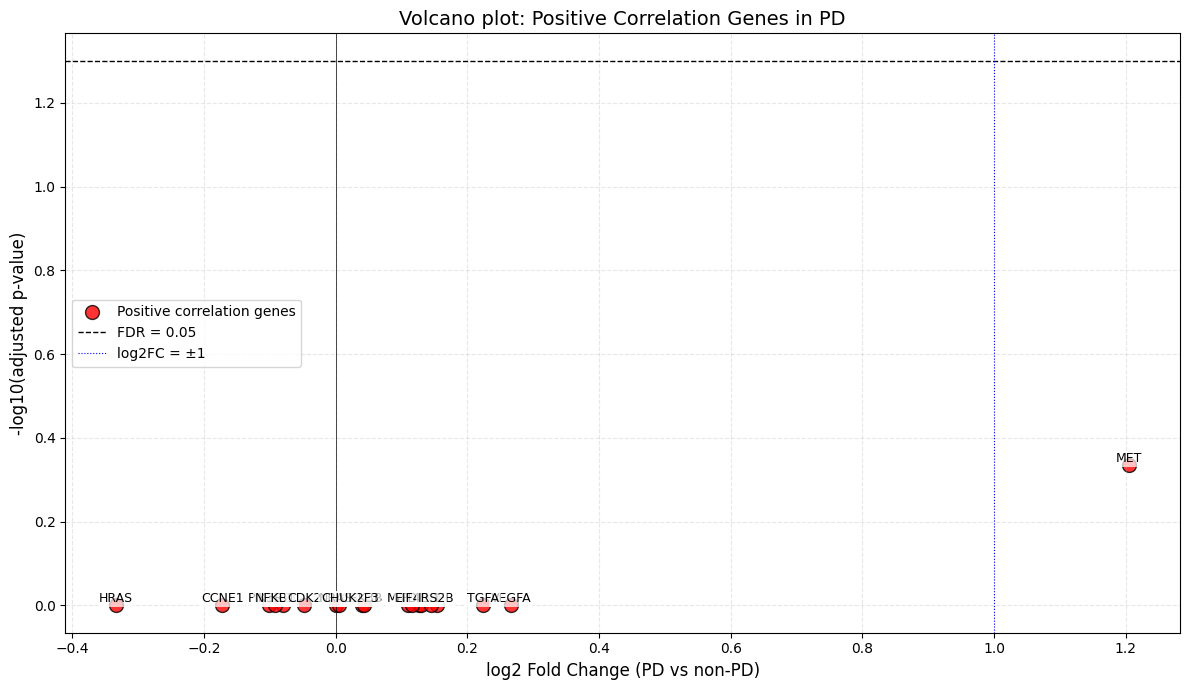

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Genes of interest (all with positive correlations)
genes = ['IRS2', 'E2F1', 'PIK3R2', 'NRAS', 'MET', 'GSK3B', 
         'NFKB1', 'BAX', 'MAPK3', 'CHUK', 'RHEB', 'PDPK1', 
         'HRAS', 'VEGFA', 'EIF4E', 'TGFA', 'E2F3', 'CDK2', 'CCNE1']

# Create figure
plt.figure(figsize=(12, 7))

# Extract data ONLY for our genes of interest
mask = results.index.isin(genes)
log2fc = results.loc[mask, 'log2FoldChange']
neg_log_padj = -np.log10(results.loc[mask, 'padj'])
gene_names = results.loc[mask].index

# Plot ONLY the genes of interest
plt.scatter(log2fc, neg_log_padj, color='red', alpha=0.8, s=100, 
            edgecolor='black', label='Positive correlation genes')

# Add gene labels with adjusted positions
for gene, x, y in zip(gene_names, log2fc, neg_log_padj):
    plt.text(x, y, gene, fontsize=9, ha='center', va='bottom', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, label='FDR = 0.05')
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=0.8, label='log2FC = ±1')

# Labels and legend
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(adjusted p-value)', fontsize=12)
plt.title('Volcano plot: Positive Correlation Genes in PD', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

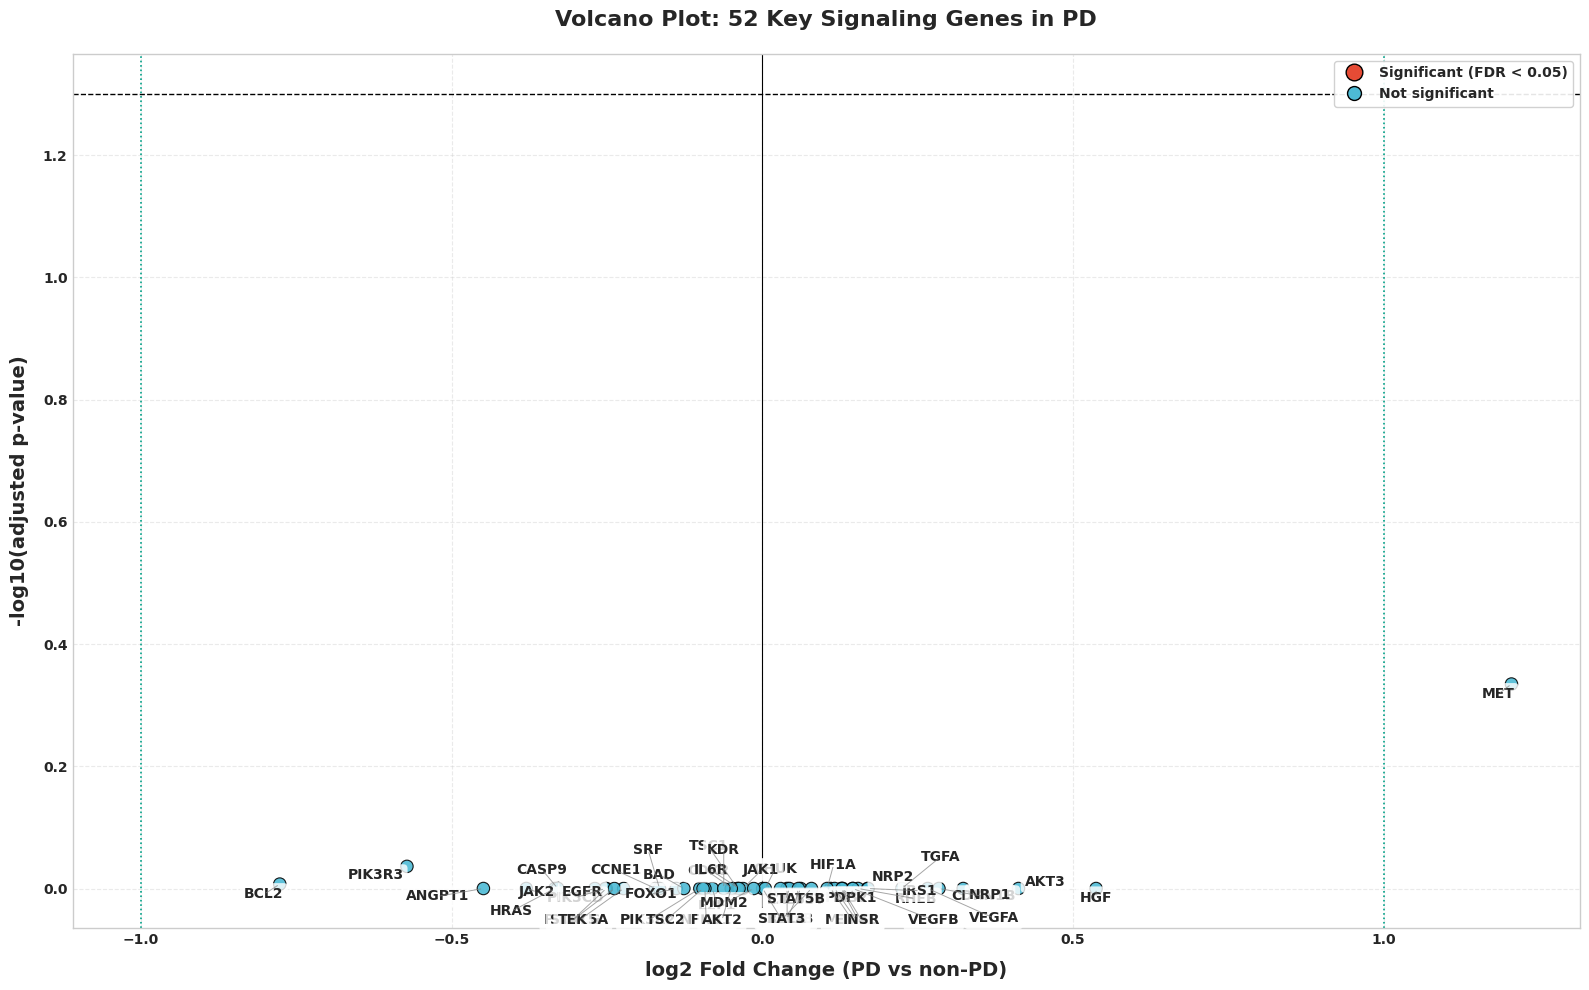

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Set style properly - using Seaborn's whitegrid style
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer versions
plt.rcParams.update({
    'font.family': 'Arial',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold'
})

# Your gene list
genes = [
    'IRS2', 'E2F1', 'PIK3R2', 'NRAS', 'MET', 'GSK3B', 'NFKB1', 'BAX', 'MAPK3', 
    'CHUK', 'RHEB', 'PDPK1', 'HRAS', 'VEGFA', 'EIF4E', 'TGFA', 'E2F3', 'CDK2', 'CCNE1',
    'RELA', 'SRF', 'FOXO1', 'JAK1', 'HGF', 'CASP9', 'PIK3CG', 'CDKN1B', 'IL6ST', 
    'AKT3', 'TSC1', 'PIK3CD', 'IRS1', 'STAT5B', 'INSR', 'IL6R', 'NRP1', 'VEGFB', 
    'STAT5A', 'BAD', 'EGFR', 'NRP2', 'TEK', 'AKT2', 'PIK3R3', 'MDM2', 'BCL2', 
    'JAK2', 'HIF1A', 'KDR', 'TSC2', 'ANGPT1', 'STAT3'
]

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Check which genes exist in results
valid_genes = [gene for gene in genes if gene in results.index]
if len(valid_genes) < len(genes):
    print(f"Warning: {len(genes) - len(valid_genes)} genes not found in results")

# Data extraction
subset = results.loc[valid_genes]
log2fc = subset['log2FoldChange'].astype(float)
neg_log_padj = -np.log10(subset['padj'].astype(float))
significant = subset['padj'] < 0.05

# Plotting
scatter = ax.scatter(
    x=log2fc,
    y=neg_log_padj,
    c=np.where(significant, '#E64B35', '#4DBBD5'),  # Red/blue
    s=np.where(significant, 150, 80),
    alpha=0.9,
    edgecolor='black',
    linewidth=0.8,
    zorder=3
)

# Reference lines
ax.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, zorder=1)
ax.axvline(0, color='black', linewidth=0.8, zorder=1)
ax.axvline(1, color='#00A087', linestyle=':', linewidth=1.2, zorder=1)
ax.axvline(-1, color='#00A087', linestyle=':', linewidth=1.2, zorder=1)

# Labeling
texts = []
for gene, x, y in zip(valid_genes, log2fc, neg_log_padj):
    texts.append(ax.text(
        x, y, gene,
        fontsize=10,
        fontweight='bold',
        ha='center',
        va='center',
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='white',
            alpha=0.8,
            edgecolor='none'
        )
    ))

adjust_text(
    texts,
    expand_points=(1.5, 1.5),
    expand_text=(1.2, 1.2),
    arrowprops=dict(
        arrowstyle='-',
        color='gray',
        lw=0.7,
        alpha=0.7
    ),
    ax=ax
)

# Legend and labels
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Significant (FDR < 0.05)',
               markerfacecolor='#E64B35', markersize=12, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Not significant',
               markerfacecolor='#4DBBD5', markersize=10, markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.9)

ax.set_xlabel('log2 Fold Change (PD vs non-PD)', fontsize=14, labelpad=10)
ax.set_ylabel('-log10(adjusted p-value)', fontsize=14, labelpad=10)
ax.set_title(f'Volcano Plot: {len(valid_genes)} Key Signaling Genes in PD', fontsize=16, pad=20)

# Final adjustments
ax.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('volcano_plot_final.png', dpi=300, bbox_inches='tight')
plt.show()


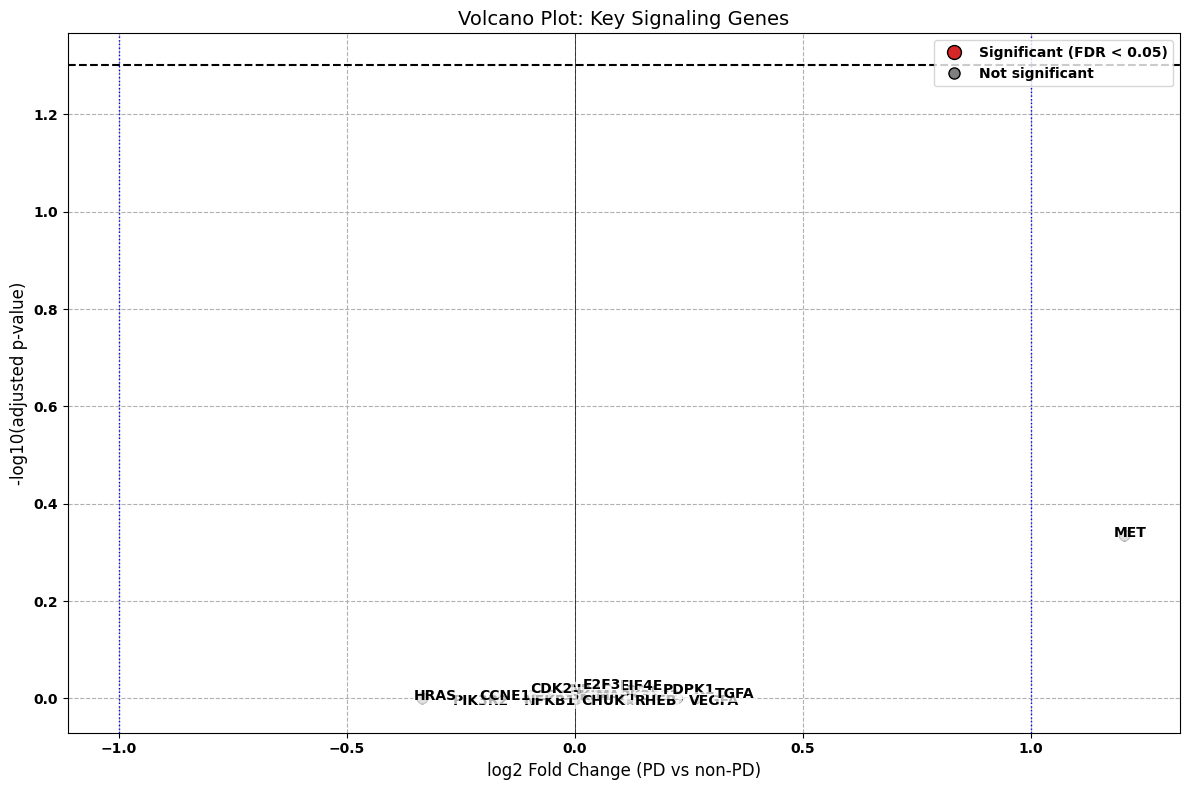

Gene Expression Results:
        log2FoldChange      padj
MET           1.205493  0.462769
GSK3B         0.039597  0.999976
IRS2          0.145296  0.999976
HRAS         -0.333911  0.999976
TGFA          0.224404  0.999976
EIF4E         0.116207  0.999976
PDPK1         0.129315  0.999976
CDK2         -0.048202  0.999976
VEGFA         0.266113  0.999976
E2F3          0.043459  0.999976
NFKB1        -0.092552  0.999976
RHEB          0.153937  0.999976
PIK3R2       -0.100666  0.999976
CCNE1        -0.172092  0.999976
MAPK3         0.109782  0.999976
E2F1         -0.080616  0.999976
BAX           0.126870  0.999976
NRAS          0.000335  0.999976
CHUK          0.004659  0.999976


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib

# Set default font to a commonly available one
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Helvetica']  # Common alternatives

# Load your DESeq2 results
results = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv', index_col=0)

# Selected genes
genes = [
    'IRS2', 'E2F1', 'PIK3R2', 'NRAS', 'MET', 'GSK3B', 'NFKB1', 'BAX', 'MAPK3',
    'CHUK', 'RHEB', 'PDPK1', 'HRAS', 'VEGFA', 'EIF4E', 'TGFA', 'E2F3', 'CDK2', 'CCNE1'
]

# Filter results
gene_results = results.loc[results.index.isin(genes)].copy()

# Create figure
plt.figure(figsize=(12, 8))
plt.style.use('default')

# Set grid and font properties
plt.rcParams.update({
    'axes.grid': True,
    'grid.linestyle': '--',
    'font.weight': 'bold'
})

# Plot points
colors = np.where(gene_results['padj'] < 0.05, '#D62728', '#7F7F7F')  # Red/Gray
sizes = np.where(gene_results['padj'] < 0.05, 100, 60)

plt.scatter(
    x=gene_results['log2FoldChange'],
    y=-np.log10(gene_results['padj']),
    c=colors,
    s=sizes,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.7
)

# Label genes
texts = []
for gene in genes:
    if gene in gene_results.index:
        x = gene_results.loc[gene, 'log2FoldChange']
        y = -np.log10(gene_results.loc[gene, 'padj'])
        texts.append(plt.text(
            x, y, gene,
            fontsize=10,
            ha='center',
            va='bottom',
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        ))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--', label='FDR = 0.05')
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=1, label='log2FC = ±1')
plt.axvline(-1, color='blue', linestyle=':', linewidth=1)

# Labels and title
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(adjusted p-value)', fontsize=12)
plt.title('Volcano Plot: Key Signaling Genes', fontsize=14)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Significant (FDR < 0.05)',
               markerfacecolor='#D62728', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Not significant',
               markerfacecolor='#7F7F7F', markersize=8, markeredgecolor='black')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('volcano_plot_selected_genes.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results
print("Gene Expression Results:")
print(gene_results[['log2FoldChange', 'padj']].sort_values('padj'))

In [ ]:
import pandas as pd
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

# Filter out genes with zero counts across all samples
counts = counts.loc[(counts != 0).any(axis=1)]

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)
stat_res.summary()

# Get results as DataFrame
results = stat_res.results_df if hasattr(stat_res, 'results_df') else pd.DataFrame({
    'baseMean': dds.counts.mean(axis=1),
    'log2FoldChange': stat_res.LFC,
    'lfcSE': stat_res.LFC_SE,
    'stat': stat_res.stat,
    'pvalue': stat_res.p_values,
    'padj': stat_res.padj
}, index=dds.counts.index)

# 5. Show top results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

# 6. Save results - WITH DIRECTORY CREATION
output_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

output_path = os.path.join(output_dir, 'deseq_results.csv')
results.to_csv(output_path)
print(f"\nResults saved to: {output_path}")

# 7. Optional: Save significant genes separately
sig_genes = results[results['padj'] < 0.05]
sig_path = os.path.join(output_dir, 'significant_genes.csv')
sig_genes.to_csv(sig_path)
print(f"Significant genes saved to: {sig_path}")

#0filtered

Fitting size factors...
... done in 0.08 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 14.99 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 17.69 seconds.

Fitting LFCs...
... done in 8.03 seconds.

Calculating cook's distance...
... done in 0.23 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 3.60 seconds.

Fitting MAP dispersions...
... done in 3.04 seconds.

Fitting LFCs...
... done in 0.67 seconds.

Running Wald tests...
... done in 9.42 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6       4425.251042       -0.144219  0.305637 -0.471864  0.637024   
TNMD           38.584134       -0.109781  0.614479 -0.178657  0.858207   
DPM1         9724.985964        0.189719  0.241286  0.786282  0.431702   
SCYL3         685.285613       -0.053223  0.116689 -0.456113  0.648309   
FIRRM        1652.466516       -0.273892  0.182569 -1.500214  0.133559   
...                  ...             ...       ...       ...       ...   
FAM90A14        3.834275       -0.559305  1.875139 -0.298274  0.765494   
GET1-SH3BGR    22.956363       -1.248565  1.046938 -1.192587  0.233031   
FAM90A18        0.011114       -0.003194  4.778886 -0.000668  0.999467   
FAM90A10        6.808952        2.940060  1.844175  1.594241  0.110882   
FAM90A7         0.198694       -1.067749  4.733834 -0.225557  0.821546   

                 padj  
TSPAN6       0.99

In [ ]:
import pandas as pd
import numpy as np
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare data with filtering
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

# Filter out genes with zero counts across all samples
counts = counts.loc[(counts != 0).any(axis=1)]

# Additional filtering - keep genes with ≥10 counts in at least 3 samples
min_counts = 10
min_samples = 3
counts = counts.loc[((counts >= min_counts).sum(axis=1) >= min_samples)]

# Load metadata
ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# Print metadata structure for verification
print("\n=== Metadata Verification ===")
print(f"Columns: {ann.columns.tolist()}")
print(f"\nUnique values in 'time_point': {ann['time_point'].unique()}")
print(f"\nValue counts:\n{ann['time_point'].value_counts()}")

# Filter for only pre- and post-treated samples (using the actual values)
ann = ann[ann['time_point'].isin(['pre-treatment', 'post-treatment'])]

# Verify we have both groups
print(f"\nAfter filtering - value counts:\n{ann['time_point'].value_counts()}")

# Check if we have samples in both groups
if len(ann['time_point'].unique()) < 2:
    raise ValueError("Error: Need both 'pre-treatment' and 'post-treatment' samples for comparison. Found only: " + 
                     str(ann['time_point'].unique()))

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
print(f"\nNumber of samples in analysis: {len(common_samples)}")
print(f"Pre-treatment samples: {len(ann[ann['time_point'] == 'pre-treatment'])}")
print(f"Post-treatment samples: {len(ann[ann['time_point'] == 'post-treatment'])}")

adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# Create a simplified time_point column for DESeq2
adata.obs['time_group'] = adata.obs['time_point'].map({
    'pre-treatment': 'pre',
    'post-treatment': 'post'
})

# 3. Run DESeq2 - comparing pre vs post treatment
try:
    dds = DeseqDataSet(
        adata=adata,
        design='~ time_group',  # Compare pre vs post
        refit_cooks=True,
        n_cpus=4
    )
    dds.deseq2()
    
    # 4. Get results
    stat_res = DeseqStats(dds, contrast=['time_group', 'post', 'pre'])  # post vs pre
    stat_res.summary()
    results = stat_res.results_df
    
    # 5. Create output directory
    output_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/pre_vs_post'
    os.makedirs(output_dir, exist_ok=True)

    # 6. Save results
    results.to_csv(os.path.join(output_dir, 'deseq_results_pre_vs_post.csv'))

    # 7. Save significant genes (FDR < 0.05)
    sig_genes = results[results['padj'] < 0.05].sort_values('padj')
    sig_genes.to_csv(os.path.join(output_dir, 'significant_genes_pre_vs_post.csv'))

    # 8. Create Volcano Plot
    plt.figure(figsize=(12, 8))
    plot_df = results.copy()
    plot_df['-log10_padj'] = -np.log10(plot_df['padj'])
    plot_df['significant'] = plot_df['padj'] < 0.05

    sns.scatterplot(
        data=plot_df,
        x='log2FoldChange',
        y='-log10_padj',
        hue='significant',
        palette={True: 'red', False: 'gray'},
        alpha=0.6,
        s=40
    )

    # Highlight top significant genes
    top_genes = plot_df.nsmallest(10, 'padj')
    for i, row in top_genes.iterrows():
        plt.text(row['log2FoldChange'], row['-log10_padj'], i, 
                 fontsize=9, ha='center', va='bottom')

    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Volcano Plot: Post-Treatment vs Pre-Treatment', fontsize=16)
    plt.xlabel('log2 Fold Change (Post/Pre)', fontsize=14)
    plt.ylabel('-log10(adjusted p-value)', fontsize=14)
    plt.legend(title='FDR < 0.05')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, 'volcano_plot_pre_vs_post.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

    print(f"\nAnalysis complete. Results saved to: {output_dir}")
    print(f"Found {len(sig_genes)} significantly differentially expressed genes")
    if len(sig_genes) > 0:
        print(f"Top significant gene: {sig_genes.index[0]} (padj={sig_genes['padj'].iloc[0]:.2e})")
    else:
        print("No significant genes found at FDR < 0.05")

except Exception as e:
    print(f"\nError during DESeq2 analysis: {str(e)}")
    print("\nDebugging information:")
    print(f"Number of pre-treatment samples: {(ann['time_point'] == 'pre-treatment').sum()}")
    print(f"Number of post-treatment samples: {(ann['time_point'] == 'post-treatment').sum()}")
    print(f"Common samples with counts data: {len(common_samples)}")

    #prevspost


=== Metadata Verification ===
Columns: ['sample_id', 'tissue', 'time_point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id']

Unique values in 'time_point': ['post-treatment' 'pre-treatment']

Value counts:
time_point
pre-treatment     67
post-treatment    13
Name: count, dtype: int64

After filtering - value counts:
time_point
pre-treatment     67
post-treatment    13
Name: count, dtype: int64

Number of samples in analysis: 80
Pre-treatment samples: 67
Post-treatment samples: 13
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.16 seconds.

Fitting dispersions...
... done in 19.47 seconds.

Fitting dispersion trend curve...
... done in 2.51 seconds.

Fitting MAP dispersions...
... done in 24.69 seconds.

Fitting LFCs...
... done in 8.43 seconds.

Calculating cook's distance...
... done in 1.62 seconds.

Replacing 1069 outlier genes.

Fitting dispersions...
... done in 4.81 seconds.

Fitting MAP dispersions...
... done in 6.01 seconds.

Fitting LFCs...
... done in 1.42 seconds.

Running Wald tests...
... done in 28.42 seconds.



Log2 fold change & Wald test p-value: time_group post vs pre
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6       4425.251042       -0.514949  0.257420 -2.000424  0.045454   
TNMD           38.584134       -1.305159  0.513898 -2.539723  0.011094   
DPM1         9724.985964       -0.784509  0.200349 -3.915706  0.000090   
SCYL3         685.285613       -0.010874  0.100819 -0.107859  0.914108   
FIRRM        1652.466516       -0.144993  0.154925 -0.935889  0.349330   
...                  ...             ...       ...       ...       ...   
FAM90A23        0.234090       -0.688010  4.039705 -0.170312  0.864765   
FAM90A14        3.579373       -2.609840  1.667845 -1.564798  0.117630   
GET1-SH3BGR    22.956363        0.461173  0.884215  0.521562  0.601975   
FAM90A10        6.808952        1.098029  1.603167  0.684912  0.493399   
FAM90A7         0.198694       -0.158862  4.026160 -0.039457  0.968526   

                 padj  
TSPAN6       0.197713  
TN

In [ ]:
# New analysis for specific samples
specific_samples = [
    '18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', 
    '18R678_0010', '18R683_0015', '18R694_0002', '18R699_0007',
    '18R700_0008', '18R429_0009', '18R298_0010', '18R647_0008',
    '18R648_0009', '18R178_0022', '18R299_0025', '18R300_0027',
    '18R659_0020', '18R661_0021', '18R301_0002', '18R302_0004',
    '18R663_0027', '18R664_0001', '18R307_0013', '18R642_0003',
    '18R645_0006', '18R653_0014', '18R432_0012', '18R460_0001',
    '18R473_0014', '18R443_0022', '18R463_0004', '18R508_0011',
    '18R702_0010', '18R656_0018', '18R657_0019', '18R673_0005',
    '18R465_0006', '18R507_0004'
]

# Filter metadata and counts for these samples
specific_ann = ann[ann['sample_id'].isin(specific_samples)]
specific_counts = counts[specific_ann['sample_id']]

# Verify groups
print("\n=== Specific Samples Analysis ===")
print(f"Pre-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'pre-treatment'])}")
print(f"Post-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'post-treatment'])}")

# Create AnnData object
specific_adata = AnnData(
    X=specific_counts.T,
    obs=specific_ann.set_index('sample_id')
)

# Create simplified time_group column
specific_adata.obs['time_group'] = specific_adata.obs['time_point'].map({
    'pre-treatment': 'pre',
    'post-treatment': 'post'
})

# Run DESeq2
try:
    specific_dds = DeseqDataSet(
        adata=specific_adata,
        design='~ time_group',
        refit_cooks=True,
        n_cpus=4
    )
    specific_dds.deseq2()
    
    # Get results
    specific_stat_res = DeseqStats(specific_dds, contrast=['time_group', 'post', 'pre'])
    specific_stat_res.summary()
    specific_results = specific_stat_res.results_df
    
    # Create output directory
    specific_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/specific_pre_vs_post'
    os.makedirs(specific_dir, exist_ok=True)
    
    # Save results
    specific_results.to_csv(os.path.join(specific_dir, 'deseq_results_specific.csv'))
    
    # Save significant genes
    specific_sig = specific_results[specific_results['padj'] < 0.05].sort_values('padj')
    specific_sig.to_csv(os.path.join(specific_dir, 'significant_genes_specific.csv'))
    
    # Create volcano plot
    plt.figure(figsize=(12, 8))
    specific_plot = specific_results.copy().replace([np.inf, -np.inf], np.nan).dropna(subset=['padj', 'log2FoldChange'])
    specific_plot['-log10_padj'] = -np.log10(specific_plot['padj'])
    specific_plot['significant'] = specific_plot['padj'] < 0.05
    
    sns.scatterplot(
        data=specific_plot,
        x='log2FoldChange',
        y='-log10_padj',
        hue='significant',
        palette={True: 'red', False: 'gray'},
        alpha=0.6,
        s=40
    )
    
    # Highlight top genes
    top_specific = specific_plot[specific_plot['significant']].nsmallest(10, 'padj')
    for i, row in top_specific.iterrows():
        plt.text(row['log2FoldChange'], row['-log10_padj'], i, 
                fontsize=9, ha='center', va='bottom')
    
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Volcano Plot: Specific Samples - Post vs Pre', fontsize=16)
    plt.xlabel('log2 Fold Change (Post/Pre)', fontsize=14)
    plt.ylabel('-log10(adjusted p-value)', fontsize=14)
    plt.legend(title='FDR < 0.05')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(specific_dir, 'volcano_specific.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\nSpecific samples analysis complete. Results saved to: {specific_dir}")
    print(f"Found {len(specific_sig)} significant genes")
    if len(specific_sig) > 0:
        print(f"Top gene: {specific_sig.index[0]} (padj={specific_sig['padj'].iloc[0]:.2e})")
    
except Exception as e:
    print(f"\nError in specific samples analysis: {str(e)}")

    #without unknow-no filtartion


=== Specific Samples Analysis ===
Pre-treatment samples: 25
Post-treatment samples: 13
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.13 seconds.

Fitting dispersions...
... done in 15.16 seconds.

Fitting dispersion trend curve...
... done in 1.51 seconds.

Fitting MAP dispersions...
... done in 65.97 seconds.

Fitting LFCs...
... done in 11.47 seconds.

Calculating cook's distance...
... done in 0.13 seconds.

Replacing 961 outlier genes.

Fitting dispersions...
... done in 5.56 seconds.

Fitting MAP dispersions...
... done in 0.73 seconds.

Fitting LFCs...
... done in 1.00 seconds.

Running Wald tests...
... done in 25.11 seconds.



Log2 fold change & Wald test p-value: time_group post vs pre
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6       3688.061001       -0.347932  0.276952 -1.256292  0.209010   
TNMD           30.918394       -1.212743  0.542825 -2.234134  0.025474   
DPM1         7727.363938       -0.584204  0.213899 -2.731216  0.006310   
SCYL3         690.816558       -0.122427  0.119892 -1.021149  0.307184   
FIRRM        1594.033861       -0.193561  0.153009 -1.265037  0.205858   
...                  ...             ...       ...       ...       ...   
FAM90A23        0.276330       -1.205271  3.216877 -0.374671  0.707905   
FAM90A14        4.729879       -1.505678  1.683435 -0.894408  0.371104   
GET1-SH3BGR    19.987066        0.877658  1.084125  0.809555  0.418196   
FAM90A10        2.415406       -0.841212  1.962008 -0.428751  0.668105   
FAM90A7         0.090659        0.412340  3.241893  0.127191  0.898789   

                 padj  
TSPAN6       0.492531  
TN

In [ ]:
# New analysis for specific samples with zero-expression filtration
specific_samples = [
    '18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', 
    '18R678_0010', '18R683_0015', '18R694_0002', '18R699_0007',
    '18R700_0008', '18R429_0009', '18R298_0010', '18R647_0008',
    '18R648_0009', '18R178_0022', '18R299_0025', '18R300_0027',
    '18R659_0020', '18R661_0021', '18R301_0002', '18R302_0004',
    '18R663_0027', '18R664_0001', '18R307_0013', '18R642_0003',
    '18R645_0006', '18R653_0014', '18R432_0012', '18R460_0001',
    '18R473_0014', '18R443_0022', '18R463_0004', '18R508_0011',
    '18R702_0010', '18R656_0018', '18R657_0019', '18R673_0005',
    '18R465_0006', '18R507_0004'
]

# 1. Filter metadata for these samples
specific_ann = ann[ann['sample_id'].isin(specific_samples)]

# 2. Filter counts for these samples and apply zero-expression filtration
specific_counts = counts[specific_ann['sample_id']]

# First filter: Remove genes with zero counts across all samples
specific_counts = specific_counts.loc[(specific_counts != 0).any(axis=1)]

# Second filter: Keep genes with ≥10 counts in at least 3 samples
min_counts = 10
min_samples = 3
specific_counts = specific_counts.loc[((specific_counts >= min_counts).sum(axis=1) >= min_samples)]

# Verify groups
print("\n=== Specific Samples Analysis ===")
print(f"Pre-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'pre-treatment'])}")
print(f"Post-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'post-treatment'])}")
print(f"\nAfter filtration:")
print(f"Total genes remaining: {len(specific_counts)}")
print(f"Total samples remaining: {len(specific_counts.columns)}")

# Create AnnData object
specific_adata = AnnData(
    X=specific_counts.T,
    obs=specific_ann.set_index('sample_id').loc[specific_counts.columns]
)

# Create simplified time_group column
specific_adata.obs['time_group'] = specific_adata.obs['time_point'].map({
    'pre-treatment': 'pre',
    'post-treatment': 'post'
})

# Run DESeq2
try:
    specific_dds = DeseqDataSet(
        adata=specific_adata,
        design='~ time_group',
        refit_cooks=True,
        n_cpus=4
    )
    specific_dds.deseq2()
    
    # Get results
    specific_stat_res = DeseqStats(specific_dds, contrast=['time_group', 'post', 'pre'])
    specific_stat_res.summary()
    specific_results = specific_stat_res.results_df
    
    # Create output directory
    specific_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/specific_pre_vs_post'
    os.makedirs(specific_dir, exist_ok=True)
    
    # Save results
    specific_results.to_csv(os.path.join(specific_dir, 'deseq_results_specific.csv'))
    
    # Save significant genes
    specific_sig = specific_results[specific_results['padj'] < 0.05].sort_values('padj')
    specific_sig.to_csv(os.path.join(specific_dir, 'significant_genes_specific.csv'))
    
    # Create volcano plot
    plt.figure(figsize=(12, 8))
    specific_plot = specific_results.copy().replace([np.inf, -np.inf], np.nan).dropna(subset=['padj', 'log2FoldChange'])
    specific_plot['-log10_padj'] = -np.log10(specific_plot['padj'])
    specific_plot['significant'] = specific_plot['padj'] < 0.05
    
    sns.scatterplot(
        data=specific_plot,
        x='log2FoldChange',
        y='-log10_padj',
        hue='significant',
        palette={True: 'red', False: 'gray'},
        alpha=0.6,
        s=40
    )
    
    # Highlight top genes
    top_specific = specific_plot[specific_plot['significant']].nsmallest(10, 'padj')
    for i, row in top_specific.iterrows():
        plt.text(row['log2FoldChange'], row['-log10_padj'], i, 
                fontsize=9, ha='center', va='bottom')
    
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Volcano Plot: Specific Samples - Post vs Pre', fontsize=16)
    plt.xlabel('log2 Fold Change (Post/Pre)', fontsize=14)
    plt.ylabel('-log10(adjusted p-value)', fontsize=14)
    plt.legend(title='FDR < 0.05')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(specific_dir, 'volcano_specific.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\nSpecific samples analysis complete. Results saved to: {specific_dir}")
    print(f"Found {len(specific_sig)} significant genes")
    if len(specific_sig) > 0:
        print(f"Top gene: {specific_sig.index[0]} (padj={specific_sig['padj'].iloc[0]:.2e})")
    
except Exception as e:
    print(f"\nError in specific samples analysis: {str(e)}")
    print("\nDebugging information:")
    print(f"Pre-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'pre-treatment'])}")
    print(f"Post-treatment samples: {len(specific_ann[specific_ann['time_point'] == 'post-treatment'])}")
    print(f"Genes after filtration: {len(specific_counts)}")
    print(f"Samples after filtration: {len(specific_counts.columns)}")

    #filered_specified without unkonwn-probably finaly


=== Specific Samples Analysis ===
Pre-treatment samples: 25
Post-treatment samples: 13

After filtration:
Total genes remaining: 17172
Total samples remaining: 38
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.23 seconds.

Fitting dispersions...
... done in 14.88 seconds.

Fitting dispersion trend curve...
... done in 1.81 seconds.

Fitting MAP dispersions...
... done in 66.87 seconds.

Fitting LFCs...
... done in 10.64 seconds.

Calculating cook's distance...
... done in 0.27 seconds.

Replacing 810 outlier genes.

Fitting dispersions...
... done in 3.48 seconds.

Fitting MAP dispersions...
... done in 1.04 seconds.

Fitting LFCs...
... done in 1.08 seconds.

Running Wald tests...
... done in 27.16 seconds.



Log2 fold change & Wald test p-value: time_group post vs pre
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6       3688.061001       -0.347932  0.276728 -1.257305  0.208643   
TNMD           30.918394       -1.212726  0.543713 -2.230451  0.025718   
DPM1         7727.363938       -0.584204  0.213772 -2.732843  0.006279   
SCYL3         690.816558       -0.122426  0.120027 -1.019989  0.307734   
FIRRM        1594.033861       -0.193561  0.153040 -1.264776  0.205952   
...                  ...             ...       ...       ...       ...   
ABCF2-H2BK1  1719.951605       -0.080171  0.164057 -0.488676  0.625071   
TBCEL-TECTA    55.704041        0.405061  0.671878  0.602880  0.546589   
FAM90A14        4.729879       -1.505768  1.689262 -0.891376  0.372728   
GET1-SH3BGR    19.987066        0.877639  1.085522  0.808495  0.418806   
FAM90A10        2.415406       -0.841294  1.935987 -0.434556  0.663885   

                 padj  
TSPAN6       0.492363  
TN

In [16]:
# Create volcano plot with proper handling of edge cases
plt.figure(figsize=(12, 8))

# Prepare the data - handle infinite values and NA p-values
plot_data = specific_results.copy()

# Replace infinite values with NA
plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NA p-values or fold changes
plot_data.dropna(subset=['padj', 'log2FoldChange'], inplace=True)

# Calculate -log10 adjusted p-values
plot_data['-log10_padj'] = -np.log10(plot_data['padj'])

# Define significance
plot_data['significant'] = plot_data['padj'] < 0.05

# Create the plot
ax = sns.scatterplot(
    data=plot_data,
    x='log2FoldChange',
    y='-log10_padj',
    hue='significant',
    palette={True: 'red', False: 'gray'},
    alpha=0.6,
    s=40
)

# Highlight top significant genes (if any exist)
if plot_data['significant'].any():
    top_genes = plot_data[plot_data['significant']].nsmallest(10, 'padj')
    for i, row in top_genes.iterrows():
        ax.text(row['log2FoldChange'], row['-log10_padj'], i,
                fontsize=9, ha='center', va='bottom')

# Add significance thresholds
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)

# Style the plot
plt.title(f'Volcano Plot: Post vs Pre Treatment (n={len(specific_counts.columns)} samples)', fontsize=16)
plt.xlabel('log2 Fold Change (Post/Pre)', fontsize=14)
plt.ylabel('-log10(adjusted p-value)', fontsize=14)
plt.legend(title='FDR < 0.05')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
volcano_path = os.path.join(specific_dir, 'volcano_plot_specific_samples.png')
plt.savefig(volcano_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"\nVolcano plot successfully saved to: {volcano_path}")


Volcano plot successfully saved to: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/specific_pre_vs_post/volcano_plot_specific_samples.png


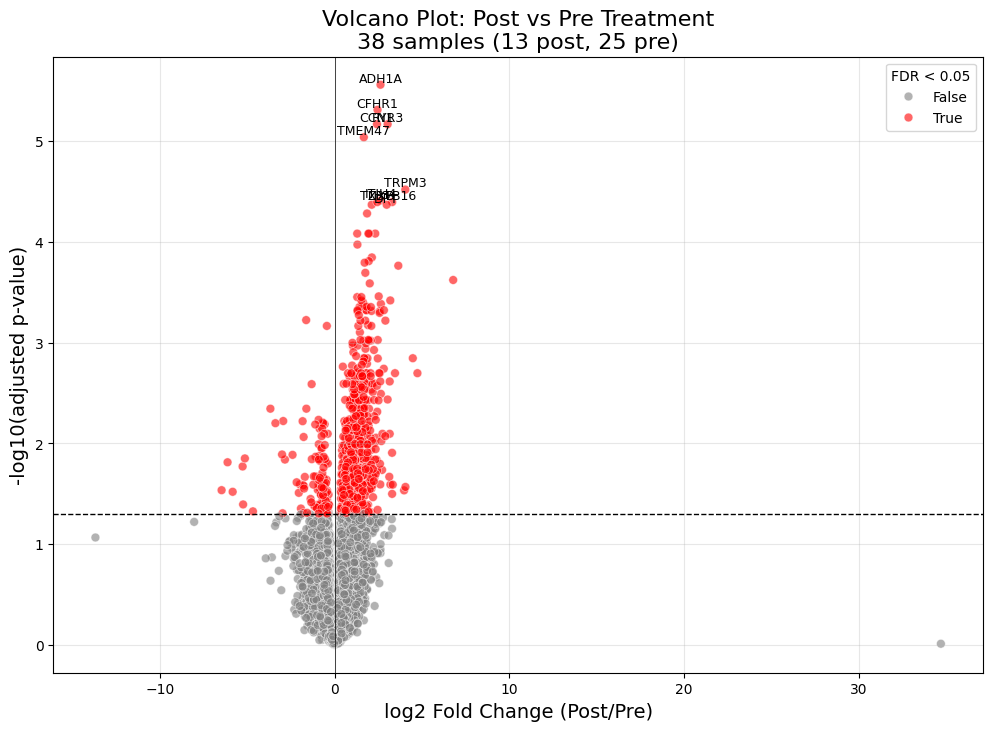

Volcano plot displayed and saved to: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/specific_pre_vs_post/volcano_plot_specific_samples.png


In [17]:
# Create and display volcano plot
plt.figure(figsize=(12, 8))

# Prepare the plot data
plot_data = specific_results.copy()
plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
plot_data.dropna(subset=['padj', 'log2FoldChange'], inplace=True)
plot_data['-log10_padj'] = -np.log10(plot_data['padj'])
plot_data['significant'] = plot_data['padj'] < 0.05

# Create the plot
ax = sns.scatterplot(
    data=plot_data,
    x='log2FoldChange',
    y='-log10_padj',
    hue='significant',
    palette={True: 'red', False: 'gray'},
    alpha=0.6,
    s=40
)

# Highlight top significant genes
if plot_data['significant'].any():
    top_genes = plot_data[plot_data['significant']].nsmallest(10, 'padj')
    for i, row in top_genes.iterrows():
        ax.text(row['log2FoldChange'], row['-log10_padj'], i,
                fontsize=9, ha='center', va='bottom')

# Add significance thresholds
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)

# Style the plot
plt.title(f'Volcano Plot: Post vs Pre Treatment\n{len(specific_counts.columns)} samples (13 post, 25 pre)', fontsize=16)
plt.xlabel('log2 Fold Change (Post/Pre)', fontsize=14)
plt.ylabel('-log10(adjusted p-value)', fontsize=14)
plt.legend(title='FDR < 0.05')
plt.grid(True, alpha=0.3)

# Save the plot
volcano_path = os.path.join(specific_dir, 'volcano_plot_specific_samples.png')
plt.savefig(volcano_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
plt.close()

print(f"Volcano plot displayed and saved to: {volcano_path}")